In [14]:
import pandas as pd
from cubist import Cubist
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib
import os
import json
import optuna
import matplotlib.pyplot as plt


In [15]:

#mir_data_path = './../datasets/neospectra_mir_v1.2.csv'
mir_data_path = './../datasets/ossl_mir_L0_v1.2.csv'


#soillab_path = './../datasets/neospectra_soillab_v1.2.csv'
soillab_path = './../datasets/ossl_soillab_L0_v1.2.csv'


#train_test_path = './../train_test_dataset/train_test_splits_mir_neo.json'
train_test_path = './../train_test_dataset/train_test_splits_mir.json'


spectra_type = "mir"  

#id_column = "id.sample_local_c"
id_column = "id.layer_uuid_txt"

In [16]:
spectral_data = pd.read_csv(mir_data_path)

soillab_data = pd.read_csv(soillab_path)

merged_data = spectral_data.merge(soillab_data, on=id_column)

print("Merged Data shape: ", merged_data.shape)


/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_59088/1150468206.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  spectral_data = pd.read_csv(mir_data_path)
/var/folders/rn/fbg5b19n6759xrg6__m9p_sr0000gn/T/ipykernel_59088/1150468206.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  soillab_data = pd.read_csv(soillab_path)


Merged Data shape:  (135651, 1792)


In [17]:
number_of_data=5000
target_column='oc_usda.c729_w.pct'


with open(train_test_path, 'r') as json_file:
    all_splits = json.load(json_file)


key = f'{target_column}_{number_of_data}'
train_ids = all_splits[f'train_{key}']
test_ids = all_splits[f'test_{key}']

print(f"Train ids : {len(train_ids)}")
print(f"Test ids : {len(test_ids)}")


train_data = merged_data[merged_data[id_column].isin(train_ids)]
test_data = merged_data[merged_data[id_column].isin(test_ids)]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train ids : 4000
Test ids : 1000
Train data shape: (4000, 1792)
Test data shape: (1000, 1792)


In [18]:
spectral_columns = [col for col in train_data.columns if 'scan_mir' in col or 'scan_visnir' in col or 'scan_nir' in col]

X_train = train_data[spectral_columns]
y_train = train_data[target_column]

print(f"X Train data shape: {X_train.shape}")
print(f"Y Train data shape: {y_train.shape}")



X_test = test_data[spectral_columns]
y_test = test_data[target_column]

print(f"X Test data shape: {X_test.shape}")
print(f"Y Test data shape: {y_test.shape}")


print(X_train.tail())

X Train data shape: (4000, 1701)
Y Train data shape: (4000,)
X Test data shape: (1000, 1701)
Y Test data shape: (1000,)
       scan_mir.600_abs  scan_mir.602_abs  scan_mir.604_abs  scan_mir.606_abs  \
85573           2.25484           2.25995           2.26871           2.27785   
85591           2.16345           2.16065           2.15553           2.15806   
85654           1.85121           1.85888           1.86607           1.87740   
85660           2.14060           2.14950           2.15872           2.17080   
85666           2.16277           2.17664           2.19370           2.20852   

       scan_mir.608_abs  scan_mir.610_abs  scan_mir.612_abs  scan_mir.614_abs  \
85573           2.28507           2.29148           2.29861           2.30790   
85591           2.17104           2.17940           2.17784           2.18137   
85654           1.89249           1.89909           1.89370           1.89019   
85660           2.18613           2.19956           2.20829          

In [19]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [20]:
def objective(trial):
    # Sample a subset of the training data
    train_data_subset = train_data.sample(n=1000, random_state=42)

    # Define hyperparameters to optimize
    committees = trial.suggest_int('committees', 1, 20)
    neighbors = trial.suggest_int('neighbors', 1, 9)

    # Preprocess the data for subset and full test data
    X_train_subset = train_data_subset[spectral_columns]
    y_train_subset = train_data_subset[target_column]

    X_test_full = test_data[spectral_columns]
    y_test_full = test_data[target_column]

    y_train_subset = np.log1p(y_train_subset)
    y_test_full = np.log1p(y_test_full)

    # Initialize and train the Cubist model
    model = Cubist()
    model.neighbors = neighbors
    model.n_committees = committees
    model.fit(X_train_subset, y_train_subset)

    # Make predictions on the testing data
    y_pred = model.predict(X_test_full)

    # Evaluate the model using RMSE
    rmse = np.sqrt(mean_squared_error(y_test_full, y_pred))
    return rmse

In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-07-01 00:02:31,125] A new study created in memory with name: no-name-52bc2c17-00c2-4bfb-9a64-3228976633ef
[I 2024-07-01 00:02:43,476] Trial 0 finished with value: 0.12158156648016498 and parameters: {'committees': 4, 'neighbors': 8}. Best is trial 0 with value: 0.12158156648016498.
[I 2024-07-01 00:03:10,319] Trial 1 finished with value: 0.11988127301395415 and parameters: {'committees': 15, 'neighbors': 6}. Best is trial 1 with value: 0.11988127301395415.
[I 2024-07-01 00:03:34,695] Trial 2 finished with value: 0.11968038290363937 and parameters: {'committees': 13, 'neighbors': 7}. Best is trial 2 with value: 0.11968038290363937.
[I 2024-07-01 00:03:55,025] Trial 3 finished with value: 0.12079627736537171 and parameters: {'committees': 10, 'neighbors': 5}. Best is trial 2 with value: 0.11968038290363937.
[I 2024-07-01 00:04:08,560] Trial 4 finished with value: 0.1226709776439124 and parameters: {'committees': 5, 'neighbors': 7}. Best is trial 2 with value: 0.11968038290363937.

Best Hyperparameters: {'committees': 17, 'neighbors': 8}


In [22]:
model = Cubist()
model.neighbors = best_params['neighbors']
model.n_committees = best_params['committees']
model.fit(X_train, y_train)

Cubist(n_committees=17, neighbors=8)

In [23]:
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Save the trained model
output_model_path = os.path.join(f'./../trained_models/cubist_model_{spectra_type}_{target_column}_{number_of_data}_logged.joblib')
os.makedirs(os.path.dirname(output_model_path), exist_ok=True)
joblib.dump(model, output_model_path)
print(f"Trained model saved to: {output_model_path}")

Root Mean Squared Error (RMSE): 0.1123100583568694
Trained model saved to: ./../trained_models/cubist_model_mir_oc_usda.c729_w.pct_5000_logged.joblib


In [24]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lccc = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)

print("Rmse: " , rmse)
print("lccc: " , lccc)
print("r2: " , r2)

Rmse:  0.1123100583568694
lccc:  0.9762652548955834
r2:  0.9529030373524838


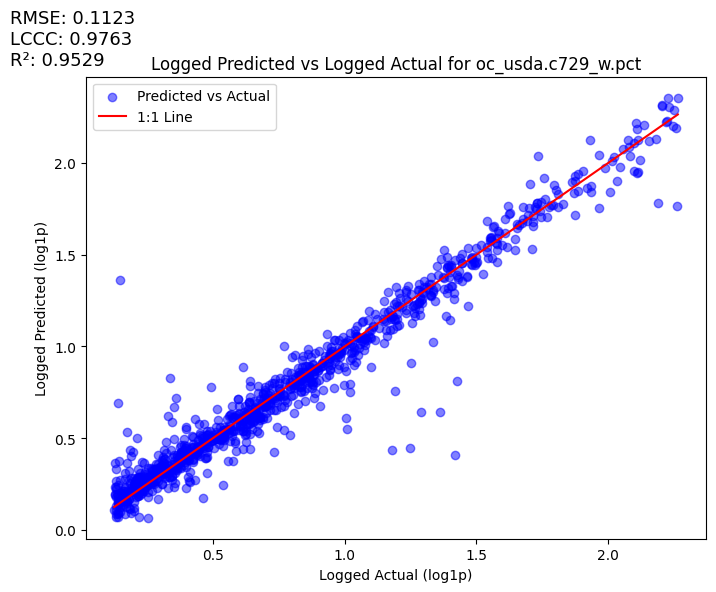

In [25]:
    # Create a scatter plot of the logged predicted vs actual values
y_true = y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='1:1 Line')
plt.title(f'Logged Predicted vs Logged Actual for {target_column}')
plt.xlabel('Logged Actual (log1p)')
plt.ylabel('Logged Predicted (log1p)')
plt.legend()
    
    # Annotate with RMSE, LCCC, and R²
textstr = f'RMSE: {rmse:.4f}\nLCCC: {lccc:.4f}\nR²: {r2:.4f}'
plt.gcf().text(0.03, 0.9, textstr, fontsize=13)
    # Save the plot
output_image_path = f'./../evaluation_results/{spectra_type}_{target_column}_evaluation_{number_of_data}_logged.png'

plt.savefig(output_image_path)
plt.show()
plt.close()
